## Predict Future Sales - Capstone project

The Goal of this Notebook is to predict Future Sales given historical data (daily granularity). This is a part of the Udacity Machine Learning Engineer Nanodegree program  and kaggle competition "Predict Future Sales": https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data 

Problem statement:

To predict the total amount of products sold in every shop and a total number of sales for each id product based on historical sales data.
Evaluation metrics:
As a metrics for evaluation of predicted target values and actual target values in test data was used root mean squared error (RMSE).

Solution description:

The provided code will be written on Python3 in Jupyter notebook with using classic data science libraries such as pandas, scikit-learn, matplotlib for plotting and visualization, catboost, xgboost, lightgbm. The type of problem is regression, that means that we need to estimate output and decide which features can impact to target. 



There are a plenty of projects implemented solutions in open notebooks of project on kaggle. I have found that some of them are really helpful for beginners and I guess I will use a few approaches and apply techniques for feature engineering, instead that reinvention the wheel.

https://www.kaggle.com/code/dimitreoliveira/model-stacking-feature-engineering-and-eda/notebook

https://www.kaggle.com/code/kyakovlev/1st-place-solution-part-1-hands-on-data/notebook 
	
https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost/notebook 



The notebook is running on python3 kernel, were used installed libraries, specified in requirements.txt

In [1]:
#!pip install catboost
#!pip install xgboost
#!pip install autogluon

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder

# Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Styling Preferences
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
# Load in dataset (cast float64 -> float32 and int32 -> int16 to save memory)
items = pd.read_csv('../input/items.csv', 
                    dtype={'item_name': 'str', 'item_id': 'int16', 'item_category_id': 'int16'}
                   )
shops = pd.read_csv('../input/shops.csv',
                    dtype={'shop_name': 'str', 'shop_id': 'int16'}
                   )
categories = pd.read_csv('../input/item_categories.csv', 
                         dtype={'item_category_name': 'str', 'item_category_id': 'int16'}
                        )
train = pd.read_csv('../input/sales_train.csv', 
                    dtype={
                        'date': 'str', 
                        'date_block_num': 'int16', 
                        'shop_id': 'int16', 
                        'item_id': 'int16', 
                        'item_price': 'float32', 
                        'item_cnt_day': 'int16'}
                   )
# set index to ID to avoid dropping it later
test  = pd.read_csv('../input/test.csv', 
                    dtype={'ID': 'int16', 'shop_id': 'int16', 'item_id': 'int16'}
                   ).set_index('ID')

In [4]:
# Cast train date from string to datetime data type
train.date = train.date.str.replace(".", "/")
train.date = pd.to_datetime(train.date)

Join the different data sets; merge onto train df

In [5]:
train = train.join(
    items, on='item_id', rsuffix='_').join(
    shops, on='shop_id', rsuffix='_').join(
    categories, on='item_category_id', rsuffix='_').drop(
    ['item_id_', 'shop_id_', 'item_category_id_'], axis=1
)

Probe the train data, it appears that there are no nan data, or missing data, which is quite good.

In [6]:
print("----------Top-5- Record----------")
print(train.head(5))
print("-----------Information-----------")
print(train.info())
print("-----------Data Types-----------")
print(train.dtypes)
print("----------Missing value-----------")
print(train.isnull().sum())
print("----------Null value-----------")
print(train.isna().sum())
print("----------Shape of Data----------")
print("Number of rows = {}, Number of columns = {}".format(len(train), len(train.columns)))
print("----------Data Description----------")
print(train.describe())

----------Top-5- Record----------
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154      999.00             1   
1 2013-03-01               0       25     2552      899.00             1   
2 2013-05-01               0       25     2552      899.00            -1   
3 2013-06-01               0       25     2554     1709.05             1   
4 2013-01-15               0       25     2555     1099.00             1   

                                  item_name  item_category_id  \
0                         ЯВЛЕНИЕ 2012 (BD)                37   
1  DEEP PURPLE  The House Of Blue Light  LP                58   
2  DEEP PURPLE  The House Of Blue Light  LP                58   
3  DEEP PURPLE  Who Do You Think We Are  LP                58   
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   

                shop_name                   item_category_name  
0  Ярославль ТЦ "Альтаир"                       Кино 

In [7]:
# look at time period of data
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


Data is from 1st January 2013 to 10th Decemer 2015, as we expect

So it turns out that a lot of data in the training set for columns "shop_id" and "item_id" does not appear in the test set. This could be perhaps because the item is no longer on sale as time goes on or shops have closed down or moved addresses. As we want to predict data in the test set, we will focus on only using "shop_id" and "item_id" that appears in the test set. 

These rows may contain information so could be worth keeping as an extra column (commented out) indicating whether or not the train_id or shop_id is in the test set. Unfortunately however, we are tight on memory and so will not be doing that in this notebook.

To make this more future proof where the "shop_id" and "item_id" might change over time (in a production environment, let's say), one may want to consider a data pipeline to constantly train and update our model with the latest information regarding shop_id and item_id's etc.. 

In [8]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
corrlate_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
correlate_train = corrlate_train[corrlate_train['item_id'].isin(test_item_ids)]

In [9]:
print('Initial data set size :', train.shape[0])
print('Data set size after matching crossovers between train and test:', correlate_train.shape[0])

Initial data set size : 2935849
Data set size after matching crossovers between train and test: 1224439


In [10]:
# Make separate column to indicate whether or not the train_id and shop_id is in test
# train['is_in_test'] = train.index.isin(correlate_train.index)
# train.head()

In [11]:
# Reduce train set to just match ones in test set regarding train_id and shop_id
train = correlate_train
len(train)

1224439

It appears we have 5 duplicated rows, let's look into these

In [12]:
print('Number of duplicates:', len(train[train.duplicated()]))

Number of duplicates: 5


The Itetm ID's are all the same, as well as the price for a number of them; other columns such as date, date_block_num look different. So this appears not to be a mistake. As there are only 5 duplicated rows, we will leave these in for now and deal with these later.

In [13]:
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
1435367,2014-02-23,13,50,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360
1496766,2014-03-23,14,21,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва МТРЦ ""Афи Молл""",Игры - XBOX 360
1671873,2014-01-05,16,50,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360
1866340,2014-12-07,18,25,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва ТРК ""Атриум""",Игры - XBOX 360
2198566,2014-12-31,23,42,21619,499.00,1,ЧЕЛОВЕК ДОЖДЯ (BD),37,"СПб ТК ""Невский Центр""",Кино - Blu-Ray


Plot the train data; look for outliers. It seems like there are a few with item price > 100000 and with item count per day > 1000. We will remove these from our training set.

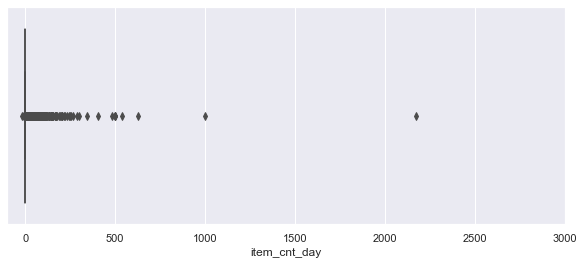

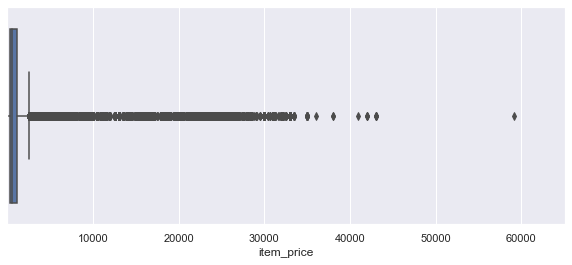

In [14]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [15]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

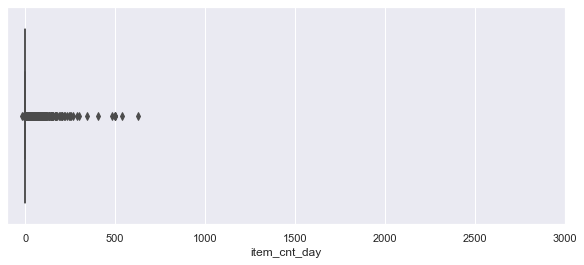

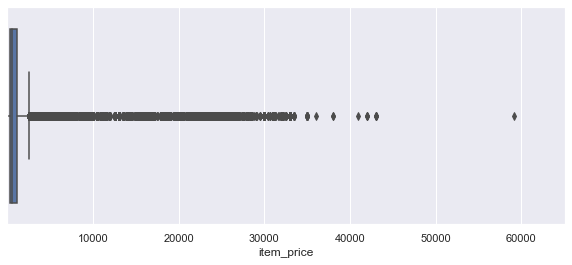

In [16]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

plt.show()

Looking better after having removed outliers.

Fill any item_price < 0 with the median item price median.

In [17]:
# Calculate the item price median
median = train.item_price.median()
print("Item Price Median = {}".format(median))
train.loc[train.item_price<0, 'item_price'] = median

Item Price Median = 549.0


In [18]:
# Double there are no item price rows < 0
train.loc[train.item_price<0, 'item_price'] 

Series([], Name: item_price, dtype: float32)

Count number of rows with item_cnt_day < 0; seems too many to be anomalous and could be an important feature. We will leave this in our dataset.

In [19]:
len(train.loc[train.item_cnt_day<0, 'item_cnt_day'])

2941

Some shops are duplicates of each other (according to name), we will fix these in our train and test set.

In [20]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Process "Shop_name" column -> shop name begins with city name.

In [21]:
# Fix erroneous shop name title
train.loc[train.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [22]:
# Create a column for city
train['city'] = train['shop_name'].str.split(' ').map(lambda x: x[0])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва


In [23]:
# Fix a city name (typo)
train.loc[train.city == '!Якутск', 'city'] = 'Якутск'

In [24]:
# Encode the city name into a code column
train['city_code'] = LabelEncoder().fit_transform(train['city'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12


Each category name contains type and subtype in its name. Treat this similarly as to how we treated shop name, split into separate columns and encode into labels (one hot encoding).

In [25]:
# Create separate column with split category name
train['split_category_name'] = train['item_category_name'].str.split('-')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code,split_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27,"[Кино , Blu, Ray]"
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]"


In [26]:
# Make column for category type and encode
train['item_category_type'] = train['split_category_name'].map(lambda x : x[0].strip())
train['item_category_type_code'] = LabelEncoder().fit_transform(train['item_category_type'])

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code,split_category_name,item_category_type,item_category_type_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27,"[Кино , Blu, Ray]",Кино,7
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9


In [27]:
# Do the same for subtype, make column wiht name if nan then set to the type
train['item_category_subtype'] = train['split_category_name'].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
# Make separate encoded column
train['item_category_subtype_code'] = LabelEncoder().fit_transform(train['item_category_subtype'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city,city_code,split_category_name,item_category_type,item_category_type_code,item_category_subtype,item_category_subtype_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль,27,"[Кино , Blu, Ray]",Кино,7,Blu,1
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,Москва,12,"[Музыка , CD локального производства]",Музыка,9,CD локального производства,2


We can now drop the following columns, having captured and encoded the necessary information from them:
-  shop_name
-  item_category_name
-  split_category_name
-  item_category_type
-  item_category_subtype

In [28]:
train = train.drop(['shop_name', 
                    'item_category_name', 
                    'split_category_name', 
                    'item_category_type', 
                    'item_category_subtype',
                   ], axis = 1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city,city_code,item_category_type_code,item_category_subtype_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Ярославль,27,7,1
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2


Looking at item name, perhaps we can reduce the number of unique types, as there are too many at the moment which our model might struggle with, so we will try to categorise some of these by just taking the first part of an item name and encoding this.

In [29]:
print("Number of unique Item names = {}".format(len(train.item_name.unique())))

Number of unique Item names = 4716


In [30]:
# Split item name, extracting first word of the string
train['item_name_split'] = train['item_name'].str.split(' ').map(lambda x : x[0].strip())
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city,city_code,item_category_type_code,item_category_subtype_code,item_name_split
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Ярославль,27,7,1,ЯВЛЕНИЕ
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL


In [31]:
print("Number of unique Item First Words = {}".format(len(train['item_name_split'].unique())))

Number of unique Item First Words = 1590


This seems substantial enough, so we will encode this once again into another column.

In [32]:
train['item_name_code'] = LabelEncoder().fit_transform(train['item_name_split'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city,city_code,item_category_type_code,item_category_subtype_code,item_name_split,item_name_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Ярославль,27,7,1,ЯВЛЕНИЕ,1587
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,Москва,12,9,2,DEL,145


And now we can drop the following columns:
-  item_name
-  item_name_split
-  city (forgot to drop in last round)

In [33]:
train = train.drop(['item_name', 
                    'item_name_split',
                    'city'
                   ], axis = 1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,item_category_type_code,item_category_subtype_code,item_name_code
0,2013-02-01,0,59,22154,999.00,1,37,27,7,1,1587
10,2013-03-01,0,25,2574,399.00,2,55,12,9,2,145
11,2013-05-01,0,25,2574,399.00,1,55,12,9,2,145
12,2013-07-01,0,25,2574,399.00,1,55,12,9,2,145
13,2013-08-01,0,25,2574,399.00,2,55,12,9,2,145


So the features above are the ones so far deemed as useful and thus are kept on. We will group by month into dataframe; then by the other columns and then aggregate the item price and count, determining the mean average and sum per month.

In [34]:
print(len(train))

1224437


In [35]:
# Group by month (date_block_num)
# Could do more complex, just want something very basic to aggregate
train_by_month = train.sort_values('date').groupby([
                                                    'date_block_num', 
                                                    'item_category_type_code',
                                                    'item_category_subtype_code',
                                                    'item_name_code',
                                                    'city_code',
                                                    'shop_id', 
                                                    'item_category_id',
                                                    'item_id',
    # Keep simple; will just use the above columns 
], as_index=False)
train_by_month.size()

date_block_num  item_category_type_code  item_category_subtype_code  item_name_code  city_code  shop_id  item_category_id  item_id
0               0                        9                           365             0          2        2                 5572       7
                                                                                     1          3        2                 5572       3
                                                                                     2          4        2                 5572       3
                                                                                     4          6        2                 5572       7
                                                                                                7        2                 5572       7
                                                                                                                                     ..
33              13                       47          

In [36]:
# everything is organised by date block num, great!
train_by_month.head().head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,item_category_type_code,item_category_subtype_code,item_name_code
32043,2013-01-01,0,2,12134,299.00,1,30,0,5,41,888
107345,2013-01-01,0,38,32,349.00,1,40,15,7,4,1
107421,2013-01-01,0,37,22088,79.00,4,83,14,13,47,1579
107443,2013-01-01,0,37,22087,79.00,2,83,14,13,47,1579
107472,2013-01-01,0,38,4885,1499.00,1,23,15,3,15,332


In [37]:
train_by_month.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,item_category_type_code,item_category_subtype_code,item_name_code
32043,2013-01-01,0,2,12134,299.00,1,30,0,5,41,888
107345,2013-01-01,0,38,32,349.00,1,40,15,7,4,1
107421,2013-01-01,0,37,22088,79.00,4,83,14,13,47,1579
107443,2013-01-01,0,37,22087,79.00,2,83,14,13,47,1579
107472,2013-01-01,0,38,4885,1499.00,1,23,15,3,15,332
...,...,...,...,...,...,...,...,...,...,...,...
2887817,2015-12-10,33,46,22102,1250.00,1,42,19,8,18,1580
2887766,2015-12-10,33,46,20801,7499.00,1,72,19,10,45,1509
2887761,2015-12-10,33,46,20629,2399.00,1,72,19,10,45,1509
2897403,2015-12-10,33,56,5232,1199.00,1,23,25,3,15,349


In [38]:
# Aggregate item price and item count
train_by_month = train_by_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [39]:
train_by_month.head()

date_block_num item_category_type_code item_category_subtype_code  \
                                                                      
0              0                       0                          9   
1              0                       0                          9   
2              0                       0                          9   
3              0                       0                          9   
4              0                       0                          9   

  item_name_code city_code shop_id item_category_id item_id item_price  \
                                                                   sum   
0            365         0       2                2    5572   10730.00   
1            365         1       3                2    5572    4770.00   
2            365         2       4                2    5572    4570.00   
3            365         4       6                2    5572   11130.00   
4            365         4       7                2    5572   11030.00   

          item_cnt_day             
     mean          sum mean count  
0 1532.86            9 1.29     7  
1 1590.00            3 1.00     3  
2 1523.33            3 1.00     3  
3 1590.00            8 1.14     7  
4 1575.71            8 1.14     7

In [40]:
# See how many rows we now have
len(train_by_month)

600158

In [41]:
# Sanity check on number of months
train_by_month.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [42]:
# Rename columns
train_by_month.columns = ['date_block_num', 
                         'item_category_type_code',
                         'item_category_subtype_code',
                         'item_name_code',
                         'city_code',
                         'shop_id', 
                         'item_category_id',
                         'item_id',
                         'sum_item_price',
                         'mean_item_price',
                         'sum_item_count',
                         'mean_item_count',
                         'transactions']
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7


As we have to apply predictions to the test set, we must ensure all possible combinations of "shop_id" and "item_id" are covered. 

To do this, we will loop through all possible combinations in our test set and append to an empty dataframe. Then we will merge that empty dataframe to our main dataframe and fill in missing na values with 0.

In [43]:
# Get all unique shop id's and item id's
shop_ids = test['shop_id'].unique()
item_ids = test['item_id'].unique()
# Initialise empty df
empty_df = []
# Loop through months and append to dataframe
for i in range(34):
    for item in item_ids:
        for shop in shop_ids:
          empty_df.append([i, shop, item])
# Turn into dataframe
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [44]:
# Merge monthly train set with the complete set (missing records will be filled with 0).
train_by_month = pd.merge(train_by_month, empty_df, on=['date_block_num','shop_id','item_id'], how='outer')
len(train_by_month)

7282800

In [45]:
# Double check we have no na records
train_by_month.isna().sum()

date_block_num                      0
item_category_type_code       6682642
item_category_subtype_code    6682642
item_name_code                6682642
city_code                     6682642
shop_id                             0
item_category_id              6682642
item_id                             0
sum_item_price                6682642
mean_item_price               6682642
sum_item_count                6682642
mean_item_count               6682642
transactions                  6682642
dtype: int64

The fact we have so many na is quiet concerning. Perhaps many more item_id or shop_id values were added in the most recent month (test data) that is not included in the training data. Whilst there may be better ways of dealing with this, we will be fill the missing na records with 0 and progress.

In [46]:
# Filll missing records with na
train_by_month.fillna(0, inplace=True)

In [47]:
train_by_month.isna().sum()

date_block_num                0
item_category_type_code       0
item_category_subtype_code    0
item_name_code                0
city_code                     0
shop_id                       0
item_category_id              0
item_id                       0
sum_item_price                0
mean_item_price               0
sum_item_count                0
mean_item_count               0
transactions                  0
dtype: int64

In [48]:
train_by_month.describe()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
count,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00
mean,16.50,0.56,1.34,58.02,1.17,31.67,3.50,11019.40,173.28,75.11,0.22,0.09,0.17
std,9.81,2.04,6.26,235.35,4.40,17.53,12.74,6252.63,2094.45,514.65,3.20,0.46,0.87
min,0.00,0.00,0.00,0.00,0.00,2.00,0.00,30.00,0.00,0.00,-4.00,-2.00,0.00
25%,8.00,0.00,0.00,0.00,0.00,16.00,0.00,5381.50,0.00,0.00,0.00,0.00,0.00
50%,16.50,0.00,0.00,0.00,0.00,34.50,0.00,11203.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,0.00,0.00,0.00,0.00,47.00,0.00,16071.50,0.00,0.00,0.00,0.00,0.00
max,33.00,13.00,47.00,1589.00,27.00,59.00,83.00,22167.00,515573.59,42990.00,1305.00,500.00,31.00


In this first feature-engineering notebook, we have inspected the data, removed outliers and identified features (as well as engineer others) we would like to use for further feature engineering to train our model with. 

As our feature-engineering steps are quite numerous, we will split it up into separate notebooks, more to come in part-2.

In [49]:
# Save this as a csv 
train_by_month.to_csv('./data/output/processed_data_pt1.csv', index=False, header=True)

FileNotFoundError: [Errno 2] No such file or directory: './data/output/processed_data_pt1.csv'

train=train_by_month.copy()
del train_by_month

In [50]:
train=train_by_month.copy()
del train_by_month

In [51]:
# Extract time based features. Make a separate column for Year and Month
train['year'] = train['date_block_num'].apply(lambda x: ((x//12) + 2013))
train['month'] = train['date_block_num'].apply(lambda x: (x % 12))

train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,9.00,1.29,7.00,2013,0
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,3.00,1.00,3.00,2013,0
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,3.00,1.00,3.00,2013,0
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,8.00,1.14,7.00,2013,0
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,8.00,1.14,7.00,2013,0


In [52]:
# Grouping data to plot

# Group by month
gp_month_mean = train.groupby(['month'], as_index=False)['sum_item_count'].mean()
gp_month_sum = train.groupby(['month'], as_index=False)['sum_item_count'].sum()

# Group by item_category 
gp_category_mean = train.groupby(['item_category_id'], as_index=False)['sum_item_count'].mean()
gp_category_sum = train.groupby(['item_category_id'], as_index=False)['sum_item_count'].sum()

# Group by shop_id
gp_shop_mean = train.groupby(['shop_id'], as_index=False)['sum_item_count'].mean()
gp_shop_sum = train.groupby(['shop_id'], as_index=False)['sum_item_count'].sum()

In [53]:
# Group by item name code
gp_item_name_code_mean = train.groupby(['item_name_code'], as_index=False)['sum_item_count'].mean()
gp_item_name_code_sum =  train.groupby(['item_name_code'], as_index=False)['sum_item_count'].sum()

# Group by city code 
gp_city_code_mean = train.groupby(['city_code'], as_index=False)['sum_item_count'].mean()
gp_city_code_sum =  train.groupby(['city_code'], as_index=False)['sum_item_count'].sum()

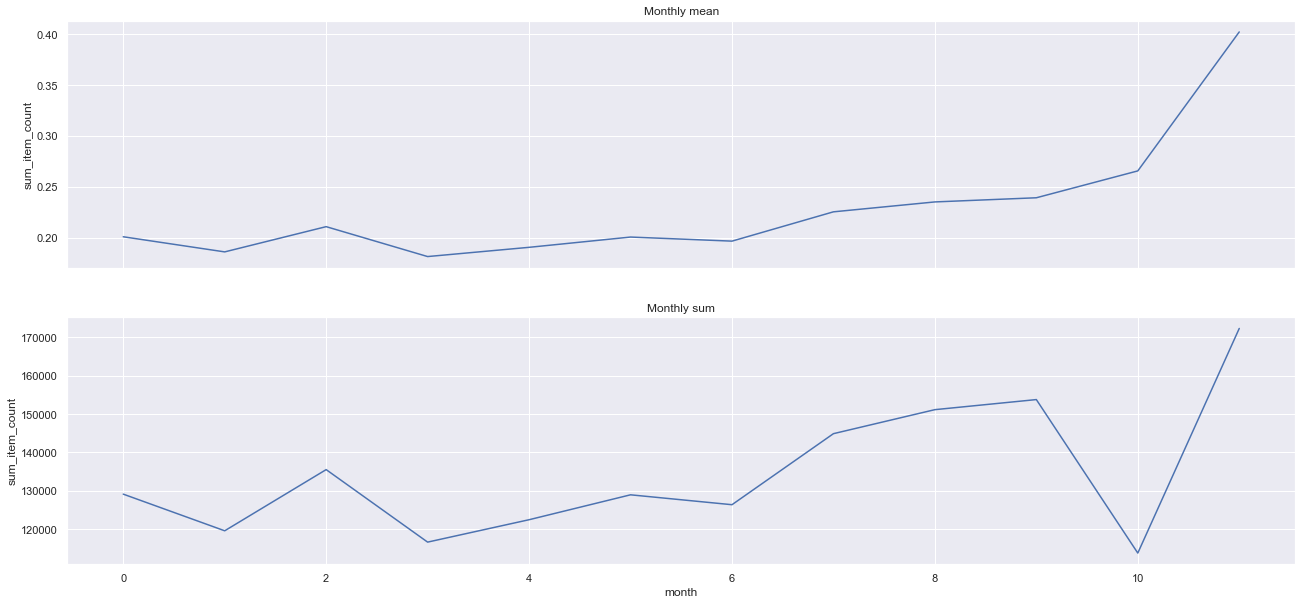

In [54]:
# Plot item count mean and sum against month
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="sum_item_count", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="sum_item_count", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

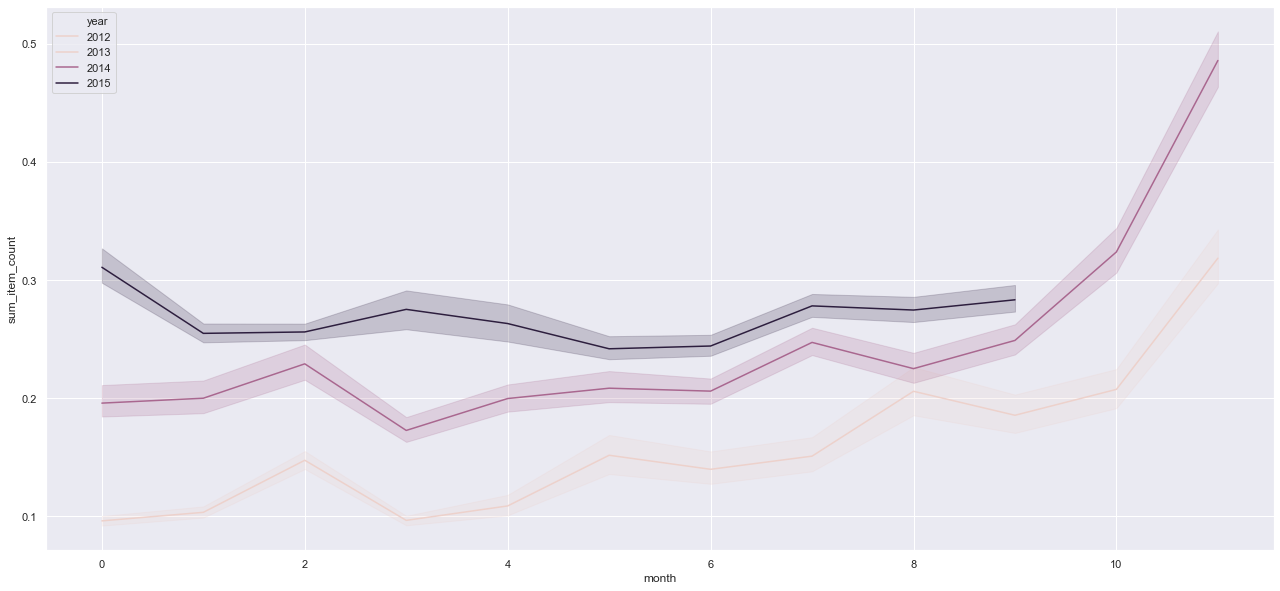

In [55]:
# Also plot the item counts by year
f, axes = plt.subplots(1, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="sum_item_count", hue="year",data=train)
plt.show()

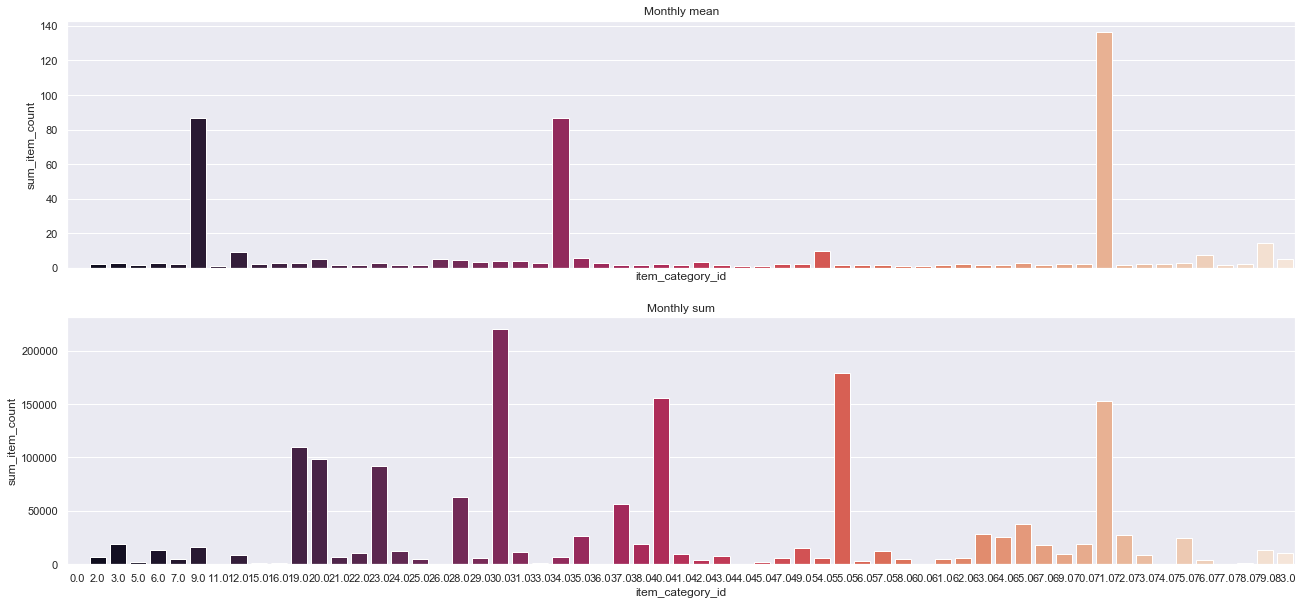

In [56]:
# We can also plot by item category id
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="sum_item_count", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="sum_item_count", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

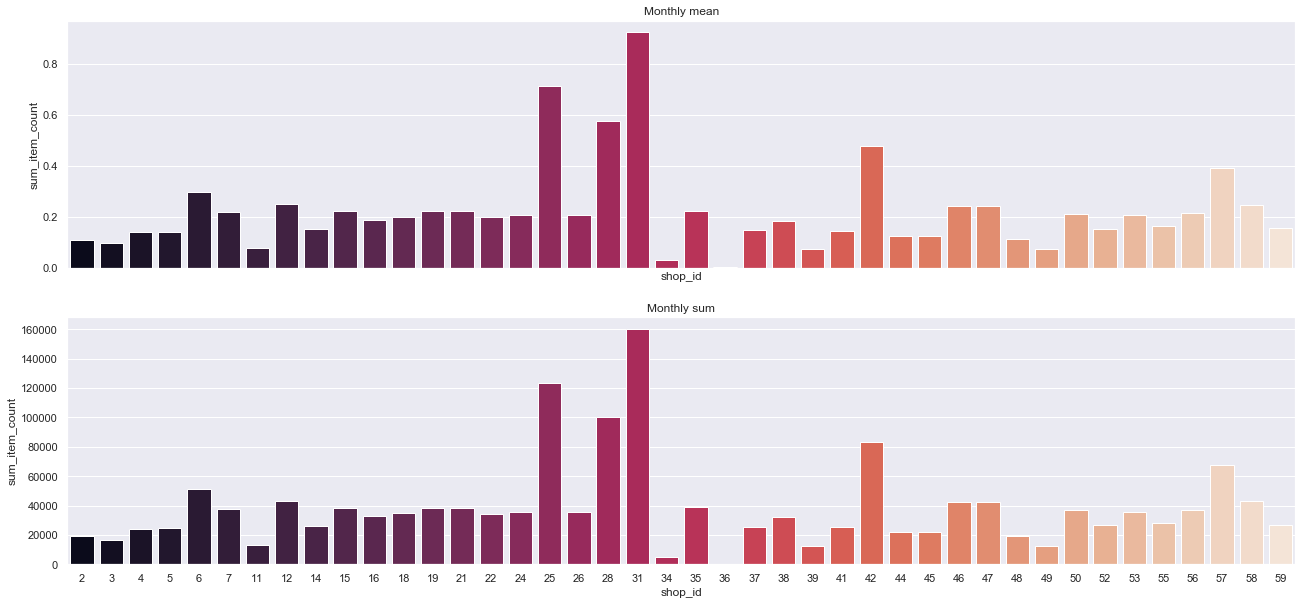

In [57]:
# We can also plot by shop id
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="sum_item_count", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="sum_item_count", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [58]:
# Shift item count for next month
train['sum_item_cnt_next_month'] = train.sort_values('date_block_num').groupby(['shop_id', 'sum_item_count'])['sum_item_count'].shift(-1)
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,9.00,1.29,7.00,2013,0,9.00
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,3.00,1.00,3.00,2013,0,3.00
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,3.00,1.00,3.00,2013,0,3.00
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,8.00,1.14,7.00,2013,0,8.00
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,8.00,1.14,7.00,2013,0,8.00


In [59]:
# Create a column with item price per unit
train['item_price_unit'] = train['sum_item_price'] // train['sum_item_count']

# Replace inf with Nan (occurs when division by zero)
train['item_price_unit'] = train['item_price_unit'].replace([np.inf, -np.inf], np.nan)
# fillna witth 0
train['item_price_unit'].fillna(0, inplace=True)

print(train['item_price_unit'].max()) # Sanity check
train.head()

94970.0


,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,9.00,1.29,7.00,2013,0,9.00,1192.00
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,3.00,1.00,3.00,2013,0,3.00,1590.00
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,3.00,1.00,3.00,2013,0,3.00,1523.00
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,8.00,1.14,7.00,2013,0,8.00,1391.00
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,8.00,1.14,7.00,2013,0,8.00,1378.00


In [60]:
# Group items and return minimum and maximum price for each item id
gp_item_price = train.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'sum_item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

gp_item_price.head()

,item_id,hist_min_item_price,hist_max_item_price
0,30,0.00,9975.00
1,31,0.00,10938.33
2,32,0.00,8027.00
3,33,0.00,2994.00
4,38,0.00,4798.00


In [61]:
# Merge into main df
train = pd.merge(train, gp_item_price, on='item_id', how='left')
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,9.00,1.29,7.00,2013,0,9.00,1192.00,0.00,18979.50
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,3.00,1.00,3.00,2013,0,3.00,1590.00,0.00,18979.50
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,3.00,1.00,3.00,2013,0,3.00,1523.00,0.00,18979.50
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,8.00,1.14,7.00,2013,0,8.00,1391.00,0.00,18979.50
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,8.00,1.14,7.00,2013,0,8.00,1378.00,0.00,18979.50


In [62]:
# Aggregate how a given item price has changed from it's minimum and maximum prices
train['price_increase'] = train['sum_item_price'] - train['hist_min_item_price']
train['price_decrease'] = train['hist_max_item_price'] - train['sum_item_price']
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,...,1.29,7.00,2013,0,9.00,1192.00,0.00,18979.50,10730.00,8249.50
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,...,1.00,3.00,2013,0,3.00,1590.00,0.00,18979.50,4770.00,14209.50
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,...,1.00,3.00,2013,0,3.00,1523.00,0.00,18979.50,4570.00,14409.50
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,...,1.14,7.00,2013,0,8.00,1391.00,0.00,18979.50,11130.00,7849.50
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,...,1.14,7.00,2013,0,8.00,1378.00,0.00,18979.50,11030.00,7949.50


In [63]:
# Initialise rolling window parameters
window_size = 3
min_periods_len = 1

# Minimum value rolling window
f_min = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).min()

# Maximum value rolling window
f_max = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).max()

# Mean value rolling window
f_mean = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).mean()

# Standard deviation rolling window
f_std = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).std()

In [64]:
# Create lists of functions and names of features to append
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

# Loop through functions list, groupby a number of our categories and apply corresponding functions
for i in range(len(function_list)):
    train[('item_cnt_%s' % function_name[i])] = train.sort_values('date_block_num').groupby([
        'shop_id', 
        'item_category_id', 
        'item_id', # Just compute primary category group bys
        # 'city_code', # Too long to compute; in an ideal world we would
        # 'item_category_type_code',
        # 'item_category_subtype_code',
        # 'item_name_code'
    ])['sum_item_count'].apply(function_list[i])

# Fill the empty std features with 0
train['item_cnt_std'].fillna(0, inplace=True)

In [65]:
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,...,9.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,...,3.00,1590.00,0.00,18979.50,4770.00,14209.50,3.00,3.00,3.00,0.00
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,...,3.00,1523.00,0.00,18979.50,4570.00,14409.50,3.00,3.00,3.00,0.00
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,...,8.00,1391.00,0.00,18979.50,11130.00,7849.50,8.00,8.00,8.00,0.00
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,...,8.00,1378.00,0.00,18979.50,11030.00,7949.50,8.00,8.00,8.00,0.00


In [66]:
# Create list of lag features (we will use up to 3 months)
lag_list = [1, 2, 3]

# Loop through lag list, groupby categories and create column for corresponding shifted lag
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train[ft_name] = train.sort_values('date_block_num').groupby([
        'shop_id', 
        'item_category_id', 
        'item_id',
        # 'city_code', # Same principle applies
        # 'item_category_type_code',
        # 'item_category_subtype_code',
        # 'item_name_code'
    ])['sum_item_count'].shift(lag)
    
    # Fill the empty shifted features with 0
    train[ft_name].fillna(0, inplace=True)

In [67]:
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,...,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,...,18979.50,4770.00,14209.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,...,18979.50,4570.00,14409.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,...,18979.50,11130.00,7849.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,...,18979.50,11030.00,7949.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00


In [68]:
# Initialise column of item trend
train['item_trend'] = train['sum_item_count']

# Compare item against lag features to capture trend
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train['item_trend'] -= train[ft_name]

# Normalise
train['item_trend'] /= len(lag_list) + 1

In [69]:
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,0.00,9.00,365.00,0.00,2,2.00,5572,10730.00,1532.86,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,0.00,9.00,365.00,1.00,3,2.00,5572,4770.00,1590.00,...,4770.00,14209.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
2,0,0.00,9.00,365.00,2.00,4,2.00,5572,4570.00,1523.33,...,4570.00,14409.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
3,0,0.00,9.00,365.00,4.00,6,2.00,5572,11130.00,1590.00,...,11130.00,7849.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00,2.00
4,0,0.00,9.00,365.00,4.00,7,2.00,5572,11030.00,1575.71,...,11030.00,7949.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00,2.00


In [70]:
train.describe()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,...,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00
mean,16.50,0.56,1.34,58.02,1.17,31.67,3.50,11019.40,173.28,75.11,...,173.28,5713.27,0.17,0.33,0.24,0.09,0.20,0.18,0.16,-0.08
std,9.81,2.04,6.26,235.35,4.40,17.53,12.74,6252.63,2094.45,514.65,...,2094.45,13659.90,2.52,4.24,3.17,1.41,3.16,3.12,3.10,1.60
min,0.00,0.00,0.00,0.00,0.00,2.00,0.00,30.00,0.00,0.00,...,0.00,0.00,-4.00,-2.00,-2.00,0.00,-4.00,-4.00,-4.00,-636.00
25%,8.00,0.00,0.00,0.00,0.00,16.00,0.00,5381.50,0.00,0.00,...,0.00,796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.50,0.00,0.00,0.00,0.00,34.50,0.00,11203.00,0.00,0.00,...,0.00,2097.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,0.00,0.00,0.00,0.00,47.00,0.00,16071.50,0.00,0.00,...,0.00,5489.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,13.00,47.00,1589.00,27.00,59.00,83.00,22167.00,515573.59,42990.00,...,515573.59,515573.59,978.00,1305.00,1090.67,571.34,1305.00,1305.00,1305.00,203.25


In [ ]:
#train.to_csv('./processed_data.csv', index=False)

In [71]:
# Create train data subset
train_data = train.query('date_block_num >= 3 and date_block_num < 30').copy()
train_data.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
25805,3,0.00,9.00,365.00,0.00,2,2.00,5572,2980.00,1490.00,...,2980.00,15999.50,1.00,2.00,1.33,0.58,1.00,1.00,9.00,-2.25
25806,3,0.00,9.00,365.00,1.00,3,2.00,5572,4470.00,1490.00,...,4470.00,14509.50,1.00,3.00,1.67,1.15,1.00,1.00,3.00,-0.50
25807,3,0.00,9.00,365.00,6.00,12,2.00,5572,1490.00,1490.00,...,1490.00,17489.50,1.00,3.00,2.00,1.41,3.00,0.00,0.00,-0.50
25808,3,0.00,9.00,365.00,7.00,14,2.00,5572,1490.00,1490.00,...,1490.00,17489.50,1.00,2.00,1.50,0.71,2.00,0.00,0.00,-0.25
25809,3,0.00,9.00,365.00,9.00,16,2.00,5572,1490.00,1490.00,...,1490.00,17489.50,1.00,5.00,3.00,2.00,3.00,5.00,3.00,-2.50


In [72]:
# Create validation data subset
validation_data = train.query('date_block_num >= 30 and date_block_num < 33').copy()
validation_data.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
489586,30,0.00,9.00,365.00,0.00,2,2.00,5572,1990.00,1990.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489587,30,0.00,9.00,365.00,2.00,4,2.00,5572,1990.00,1990.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489588,30,0.00,9.00,365.00,5.00,11,2.00,5572,1322.00,1322.00,...,1322.00,17657.50,1.00,1.00,1.00,0.00,1.00,1.00,3.00,-1.00
489589,30,0.00,9.00,365.00,7.00,14,2.00,5572,1990.00,1990.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489590,30,0.00,9.00,365.00,12.00,28,2.00,5572,1590.00,1590.00,...,1590.00,17389.50,1.00,2.00,1.33,0.58,2.00,1.00,5.00,-1.75


In [73]:
# Create test data subset
test_data = train.query('date_block_num == 33').copy()
test_data.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
571478,33,0.00,9.00,365.00,4.00,7,2.00,5572,1790.00,1790.00,...,1790.00,17189.50,1.00,2.00,1.33,0.58,1.00,2.00,1.00,-0.75
571479,33,0.00,9.00,365.00,6.00,12,2.00,5572,1300.00,1300.00,...,1300.00,17679.50,1.00,1.00,1.00,0.00,1.00,1.00,2.00,-0.75
571480,33,0.00,9.00,365.00,12.00,24,2.00,5572,1790.00,1790.00,...,1790.00,17189.50,1.00,2.00,1.33,0.58,2.00,1.00,2.00,-1.00
571481,33,0.00,9.00,366.00,2.00,4,2.00,5643,3290.00,3290.00,...,3290.00,31970.00,1.00,2.00,1.33,0.58,1.00,2.00,1.00,-0.75
571482,33,0.00,9.00,366.00,3.00,5,2.00,5637,2798.00,2798.00,...,2798.00,17122.00,1.00,2.00,1.33,0.58,1.00,2.00,2.00,-1.00


In [74]:
print('Train set records:', train_data.shape[0])
print('Validation set records:', validation_data.shape[0])
print('Test set records:', test_data.shape[0])

Train set records: 5783400
Validation set records: 642600
Test set records: 214200


In [75]:
test_data.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
571478,33,0.00,9.00,365.00,4.00,7,2.00,5572,1790.00,1790.00,...,1790.00,17189.50,1.00,2.00,1.33,0.58,1.00,2.00,1.00,-0.75
571479,33,0.00,9.00,365.00,6.00,12,2.00,5572,1300.00,1300.00,...,1300.00,17679.50,1.00,1.00,1.00,0.00,1.00,1.00,2.00,-0.75
571480,33,0.00,9.00,365.00,12.00,24,2.00,5572,1790.00,1790.00,...,1790.00,17189.50,1.00,2.00,1.33,0.58,2.00,1.00,2.00,-1.00
571481,33,0.00,9.00,366.00,2.00,4,2.00,5643,3290.00,3290.00,...,3290.00,31970.00,1.00,2.00,1.33,0.58,1.00,2.00,1.00,-0.75
571482,33,0.00,9.00,366.00,3.00,5,2.00,5637,2798.00,2798.00,...,2798.00,17122.00,1.00,2.00,1.33,0.58,1.00,2.00,2.00,-1.00


In [76]:
# Merge with test competition data to ensure test data is in the correct order.

# Load in competition test  dataset proviided
test_competition  = pd.read_csv('../input/test.csv', 
                    dtype={'ID': 'int16', 'shop_id': 'int16', 'item_id': 'int16'}
                   ).set_index('ID')
test_competition.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [77]:
# Merge and check
test_X = pd.merge(test_competition, test_data, on=['shop_id', 'item_id'], how='left')
print(len(test_X))
test_X.head()

214200


,shop_id,item_id,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,item_category_id,sum_item_price,mean_item_price,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,5,5037,33.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,25990.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,5,5320,33.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,5,5233,33.00,3.00,9.00,349.00,3.00,19.00,1199.00,1199.00,...,1199.00,5992.75,1.00,3.00,1.67,1.15,3.00,1.00,2.00,-1.25
3,5,5232,33.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,4796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,5268,33.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [83]:
test_X

,shop_id,item_id,item_category_type_code,item_category_subtype_code,item_name_code,city_code,item_category_id,sum_item_price,mean_item_price,sum_item_count,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,5,5037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,25990.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,5,5320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,5,5233,3.00,9.00,349.00,3.00,19.00,1199.00,1199.00,1.00,...,1199.00,5992.75,1.00,3.00,1.67,1.15,3.00,1.00,2.00,-1.25
3,5,5232,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,4796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,5268,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,9.00,2.00,1337.00,18.00,55.00,99.00,99.00,1.00,...,99.00,2090.00,1.00,1.00,1.00,0.00,1.00,1.00,2.00,-0.75
214196,45,16188,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1359.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
214197,45,15757,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
214198,45,19648,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [78]:
# Create X and Y Subsets for train, val and test
train_X = train_data.drop(['date_block_num', 'sum_item_cnt_next_month'], axis=1)
train_Y = train_data['sum_item_cnt_next_month']

validation_X = validation_data.drop(['date_block_num', 'sum_item_cnt_next_month'], axis=1)
validation_Y = validation_data['sum_item_cnt_next_month']

test_X = test_X.drop(['date_block_num', 'sum_item_cnt_next_month'], axis=1)

In [79]:
# Too slow so will not replace missing values with mean
datasets = [train_X, train_Y, validation_X, validation_Y, test_X]

# Replace missing values with the median of the column. 
for dataset in datasets:
    dataset.fillna(dataset.median(), inplace=True)

In [80]:
# Sanity check number we have no na.
print("Train X Null:", train_X.isnull().sum().sum())
print("Test X Null:", validation_X.isnull().sum().sum())
print("Test X Null:", test_X.isnull().sum().sum())

Train X Null: 0
Test X Null: 0
Test X Null: 0


In [81]:
# Sanity check number we have no na.
print("Train Y Null:", train_Y.isnull().sum())
print("Test X Null:", validation_Y.isnull().sum())

Train Y Null: 0
Test X Null: 0


In [84]:
print('Train set records:', train_data.shape[0])
print('Validation set records:', validation_data.shape[0])
print('Test set records:', test_data.shape[0])

Train set records: 5783400
Validation set records: 642600
Test set records: 214200


In [85]:
# Sanity check the order
test_X.head()

,shop_id,item_id,item_category_type_code,item_category_subtype_code,item_name_code,city_code,item_category_id,sum_item_price,mean_item_price,sum_item_count,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,5,5037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,25990.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,5,5320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,5,5233,3.00,9.00,349.00,3.00,19.00,1199.00,1199.00,1.00,...,1199.00,5992.75,1.00,3.00,1.67,1.15,3.00,1.00,2.00,-1.25
3,5,5232,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,4796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,5268,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [86]:
train_X.head()

,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
25805,0.00,9.00,365.00,0.00,2,2.00,5572,2980.00,1490.00,2.00,...,2980.00,15999.50,1.00,2.00,1.33,0.58,1.00,1.00,9.00,-2.25
25806,0.00,9.00,365.00,1.00,3,2.00,5572,4470.00,1490.00,3.00,...,4470.00,14509.50,1.00,3.00,1.67,1.15,1.00,1.00,3.00,-0.50
25807,0.00,9.00,365.00,6.00,12,2.00,5572,1490.00,1490.00,1.00,...,1490.00,17489.50,1.00,3.00,2.00,1.41,3.00,0.00,0.00,-0.50
25808,0.00,9.00,365.00,7.00,14,2.00,5572,1490.00,1490.00,1.00,...,1490.00,17489.50,1.00,2.00,1.50,0.71,2.00,0.00,0.00,-0.25
25809,0.00,9.00,365.00,9.00,16,2.00,5572,1490.00,1490.00,1.00,...,1490.00,17489.50,1.00,5.00,3.00,2.00,3.00,5.00,3.00,-2.50


In [87]:
validation_X.head()

,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
489586,0.00,9.00,365.00,0.00,2,2.00,5572,1990.00,1990.00,1.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489587,0.00,9.00,365.00,2.00,4,2.00,5572,1990.00,1990.00,1.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489588,0.00,9.00,365.00,5.00,11,2.00,5572,1322.00,1322.00,1.00,...,1322.00,17657.50,1.00,1.00,1.00,0.00,1.00,1.00,3.00,-1.00
489589,0.00,9.00,365.00,7.00,14,2.00,5572,1990.00,1990.00,1.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489590,0.00,9.00,365.00,12.00,28,2.00,5572,1590.00,1590.00,1.00,...,1590.00,17389.50,1.00,2.00,1.33,0.58,2.00,1.00,5.00,-1.75


In [ ]:
# Save dataframes as csv files 
'''pd.DataFrame(train_X).to_csv(os.path.join(data_dir, 'train_X.csv'), header=True, index=True)
pd.DataFrame(train_Y).to_csv(os.path.join(data_dir, 'train_Y.csv'), header=True, index=True)

pd.DataFrame(validation_X).to_csv(os.path.join(data_dir, 'validation_X.csv'), header=True, index=True)
pd.DataFrame(validation_Y).to_csv(os.path.join(data_dir, 'validation_Y.csv'), header=True, index=True)

pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test_X.csv'), header=True, index=True)'''

## Here I am creating the List of Regression Algorithms for testing

In [117]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


import xgboost as xgb
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor
#import optuna
#import lightgbm
#from lightgbm import LGBMRegressor

ModuleNotFoundError: No module named 'catboost'

In [116]:
!pip install catboost

You should consider upgrading via the 'c:\users\128524\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [124]:
train_X

,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
25805,0.00,9.00,365.00,0.00,2,2.00,-60,2980.00,1490.00,2.00,...,2980.00,15999.50,1.00,2.00,1.33,0.58,1.00,1.00,9.00,-2.25
25806,0.00,9.00,365.00,1.00,3,2.00,-60,4470.00,1490.00,3.00,...,4470.00,14509.50,1.00,3.00,1.67,1.15,1.00,1.00,3.00,-0.50
25807,0.00,9.00,365.00,6.00,12,2.00,-60,1490.00,1490.00,1.00,...,1490.00,17489.50,1.00,3.00,2.00,1.41,3.00,0.00,0.00,-0.50
25808,0.00,9.00,365.00,7.00,14,2.00,-60,1490.00,1490.00,1.00,...,1490.00,17489.50,1.00,2.00,1.50,0.71,2.00,0.00,0.00,-0.25
25809,0.00,9.00,365.00,9.00,16,2.00,-60,1490.00,1490.00,1.00,...,1490.00,17489.50,1.00,5.00,3.00,2.00,3.00,5.00,3.00,-2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536567,0.00,0.00,0.00,0.00,46,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6536568,0.00,0.00,0.00,0.00,41,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6536569,0.00,0.00,0.00,0.00,44,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6536570,0.00,0.00,0.00,0.00,39,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [126]:
from sklearn.ensemble import ExtraTreesRegressor
lr = LinearRegression()
lr.fit(train_X, train_Y)

MemoryError: Unable to allocate 596. MiB for an array with shape (27, 5783400) and data type float32

In [98]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=30, verbose=True, min_samples_leaf=100, n_jobs=1)
rfr.fit(train_X, train_Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.9min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=100,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=1, oob_score=False,
                      random_state=None, verbose=True, warm_start=False)

In [101]:
X_cols = train_X.columns
pd.DataFrame({'f':rfr.feature_importances_, 'v': X_cols}).sort_values('f')


,f,v
15,0.00,hist_min_item_price
5,0.00,item_category_id
0,0.00,item_category_type_code
2,0.00,item_name_code
6,0.00,item_id
24,0.00,item_cnt_shifted2
20,0.00,item_cnt_max
23,0.00,item_cnt_shifted1
11,0.00,transactions
1,0.00,item_category_subtype_code


In [102]:
rfr.score(train_X, train_Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.3s finished


0.6983871790255134

In [103]:
rfr.score(validation_X, validation_Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


0.7745341514661451

In [107]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int8)
    return df

train_X = downcast_dtypes(train_X)

In [108]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5783400 entries, 25805 to 6536571
Data columns (total 27 columns):
item_category_type_code       float16
item_category_subtype_code    float16
item_name_code                float16
city_code                     float16
shop_id                       int8
item_category_id              float16
item_id                       int8
sum_item_price                float32
mean_item_price               float32
sum_item_count                float16
mean_item_count               float16
transactions                  float16
year                          int8
month                         int8
item_price_unit               float16
hist_min_item_price           float32
hist_max_item_price           float32
price_increase                float32
price_decrease                float32
item_cnt_min                  float16
item_cnt_max                  float16
item_cnt_mean                 float16
item_cnt_std                  float16
item_cnt_shifted1    

In [110]:
validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642600 entries, 489586 to 7097279
Data columns (total 27 columns):
item_category_type_code       642600 non-null float64
item_category_subtype_code    642600 non-null float64
item_name_code                642600 non-null float64
city_code                     642600 non-null float64
shop_id                       642600 non-null int64
item_category_id              642600 non-null float64
item_id                       642600 non-null int64
sum_item_price                642600 non-null float32
mean_item_price               642600 non-null float32
sum_item_count                642600 non-null float64
mean_item_count               642600 non-null float64
transactions                  642600 non-null float64
year                          642600 non-null int64
month                         642600 non-null int64
item_price_unit               642600 non-null float64
hist_min_item_price           642600 non-null float32
hist_max_item_price        

In [111]:
validation_X = downcast_dtypes(validation_X)

In [114]:
validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642600 entries, 489586 to 7097279
Data columns (total 27 columns):
item_category_type_code       642600 non-null float16
item_category_subtype_code    642600 non-null float16
item_name_code                642600 non-null float16
city_code                     642600 non-null float16
shop_id                       642600 non-null int8
item_category_id              642600 non-null float16
item_id                       642600 non-null int8
sum_item_price                642600 non-null float32
mean_item_price               642600 non-null float32
sum_item_count                642600 non-null float16
mean_item_count               642600 non-null float16
transactions                  642600 non-null float16
year                          642600 non-null int8
month                         642600 non-null int8
item_price_unit               642600 non-null float16
hist_min_item_price           642600 non-null float32
hist_max_item_price           6

In [115]:
validation_X

,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
489586,0.00,9.00,365.00,0.00,2,2.00,-60,1990.00,1990.00,1.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489587,0.00,9.00,365.00,2.00,4,2.00,-60,1990.00,1990.00,1.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489588,0.00,9.00,365.00,5.00,11,2.00,-60,1322.00,1322.00,1.00,...,1322.00,17657.50,1.00,1.00,1.00,0.00,1.00,1.00,3.00,-1.00
489589,0.00,9.00,365.00,7.00,14,2.00,-60,1990.00,1990.00,1.00,...,1990.00,16989.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
489590,0.00,9.00,365.00,12.00,28,2.00,-60,1590.00,1590.00,1.00,...,1590.00,17389.50,1.00,2.00,1.33,0.58,2.00,1.00,5.00,-1.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097275,0.00,0.00,0.00,0.00,46,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7097276,0.00,0.00,0.00,0.00,41,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7097277,0.00,0.00,0.00,0.00,44,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7097278,0.00,0.00,0.00,0.00,39,0.00,-55,0.00,0.00,0.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [113]:
import timer

ts = time.time()
from xgboost import XGBRegressor



model = XGBRegressor()
model.fit(
    train_X, 
    train_Y, 
    eval_metric="rmse", 
    eval_set=[(train_X, train_Y), (validation_X, validation_Y)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

MemoryError: Unable to allocate 1.16 GiB for an array with shape (5783400, 27) and data type float64

In [96]:
models = [('LR', LinearRegression()),
          ('LASSO', Lasso()),
          ('EN', ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('S-LR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])),
          ('S-LASSO', Pipeline([('Scaler', StandardScaler()), ('LASSO', Lasso())])),
          ('S-EN', Pipeline([('Scaler', StandardScaler()), ('EN', ElasticNet())])),
          ('S-KNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])),
          ('S-CART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])), 
          ('S-SVR', Pipeline([('Scaler', StandardScaler()), ('SVR', SVR(gamma='auto'))])), 
          ('S-AB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostRegressor())])), 
          ('S-GBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingRegressor())])), 
          ('S-RF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor(n_estimators=10))])), 
          ('S-ET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesRegressor(n_estimators=10))])),
          #('XGB', XGBRegressor(categorical_columns)),
          #('CatBoost', CatBoostRegressor(cat_features = categorical_columns, verbose=0)),
          #('LGBM',LGBMRegressor())
          ]

# ('SVR', SVR(gamma='auto'))

In [97]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)


## Here I am creating a loop to test all models 

In [ ]:
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

# Visual Comparison of Algorithm Performance 

In [ ]:
fig = plt.figure(figsize=(10,4), dpi= 100, facecolor='lightblue', edgecolor='w')
fig.suptitle('Algorithm Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()